### Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os

## Visualization Code

### Vis Code for Tasks 1-3

In [ ]:
# unnormalizes images
def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean


In [ ]:
# Plot Examples
def plot_comparison(original, adversarial, orig_label, adv_label, true_label, idx):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    orig_img = unnormalize(original.cpu(), mean_norms, std_norms).permute(1, 2, 0).numpy()
    adv_img = unnormalize(adversarial.cpu(), mean_norms, std_norms).permute(1, 2, 0).numpy()

    axes[0].imshow(np.clip(orig_img, 0, 1))
    axes[0].set_title(f"Original\nTrue: {true_label}\nPred: {orig_label}")
    axes[0].axis('off')

    axes[1].imshow(np.clip(adv_img, 0, 1))
    axes[1].set_title(f"Adversarial\nTrue: {true_label}\nPred: {adv_label}")
    axes[1].axis('off')

    plt.suptitle(f"Example {idx}")
    plt.show()

### Visualization Code for Task 4

In [ ]:
def plot_patch_comparison(original, adversarial, orig_label, adv_label, true_label, idx, x_start, y_start, patch_size=32):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    orig_img = unnormalize(original.cpu(), mean_norms, std_norms).permute(1, 2, 0).numpy()
    adv_img = unnormalize(adversarial.cpu(), mean_norms, std_norms).permute(1, 2, 0).numpy()

    axes[0].imshow(np.clip(orig_img, 0, 1))
    axes[0].set_title(f"Original\nTrue: {true_label}\nPred: {orig_label}")
    axes[0].axis('off')

    axes[1].imshow(np.clip(adv_img, 0, 1))
    rect = patches.Rectangle((x_start, y_start), patch_size, patch_size,
                             linewidth=2, edgecolor='red', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].set_title(f"Adversarial (Patch)\nTrue: {true_label}\nPred: {adv_label}")
    axes[1].axis('off')

    plt.suptitle(f"Example {idx}")
    plt.show()

## Task 1: Load Model

In [ ]:
# Load pretrained ResNet-34
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').eval().cuda()

### Load Dataset

In [ ]:
!unzip TestDataSet.zip -d TestDataSet

Archive:  TestDataSet.zip
   creating: TestDataSet/TestDataSet/
   creating: TestDataSet/TestDataSet/n02795169/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02795169  
   creating: TestDataSet/TestDataSet/n02769748/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02769748  
   creating: TestDataSet/TestDataSet/n02834397/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02834397  
   creating: TestDataSet/TestDataSet/n02917067/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02917067  
   creating: TestDataSet/TestDataSet/n02808304/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02808304  
   creating: TestDataSet/TestDataSet/n03016953/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n03016953  
   creating: TestDataSet/TestDataSet/n02793495/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02793495  
   creating: TestDataSet/TestDataSet/n02814533/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02814533  
   creating: TestDataSet/TestDataSet/n02837789/
  inflating: TestDataSet

In [ ]:
# ImageNet normalization
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "/content/TestDataSet/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Load JSON mapping file
with open('TestDataSet/TestDataSet/labels_list.json', 'r') as f:
    labels_list = json.load(f)

# Convert to a dictionary: index → class name
label_map = {}
for item in labels_list:
    idx, name = item.split(': ', 1)
    label_map[int(idx)] = name

# Example check
print(label_map[401])  # should print 'accordion'
print(dataset.class_to_idx)

original_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)



accordion
{'n02672831': 0, 'n02676566': 1, 'n02687172': 2, 'n02690373': 3, 'n02692877': 4, 'n02699494': 5, 'n02701002': 6, 'n02704792': 7, 'n02708093': 8, 'n02727426': 9, 'n02730930': 10, 'n02747177': 11, 'n02749479': 12, 'n02769748': 13, 'n02776631': 14, 'n02777292': 15, 'n02782093': 16, 'n02783161': 17, 'n02786058': 18, 'n02787622': 19, 'n02788148': 20, 'n02790996': 21, 'n02791124': 22, 'n02791270': 23, 'n02793495': 24, 'n02794156': 25, 'n02795169': 26, 'n02797295': 27, 'n02799071': 28, 'n02802426': 29, 'n02804414': 30, 'n02804610': 31, 'n02807133': 32, 'n02808304': 33, 'n02808440': 34, 'n02814533': 35, 'n02814860': 36, 'n02815834': 37, 'n02817516': 38, 'n02823428': 39, 'n02823750': 40, 'n02825657': 41, 'n02834397': 42, 'n02835271': 43, 'n02837789': 44, 'n02840245': 45, 'n02841315': 46, 'n02843684': 47, 'n02859443': 48, 'n02860847': 49, 'n02865351': 50, 'n02869837': 51, 'n02870880': 52, 'n02871525': 53, 'n02877765': 54, 'n02879718': 55, 'n02883205': 56, 'n02892201': 57, 'n02892767': 

### Evaluation for baseline accuracy

In [ ]:
# Build dummy local-to-ImageNet index mapping
local_to_imagenet = {local_idx: 401 + local_idx for local_idx in range(100)}

# Example check
print(local_to_imagenet[0])   # should be 401
print(local_to_imagenet[99])  # should be 500


# Build: class name → ImageNet index
imagenet_map = {}
for item in labels_list:
    idx, name = item.split(': ', 1)
    imagenet_map[name] = int(idx)


401
500


In [ ]:
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images, labels = images.cuda(), labels.cuda()

        # Map local labels to ImageNet indices
        mapped_labels = torch.tensor(
            [local_to_imagenet[l.item()] for l in labels],
            device=labels.device
        )

        outputs = model(images)
        _, preds = outputs.topk(5, 1, True, True)

        top1_correct += (preds[:, 0] == mapped_labels).sum().item()
        top5_correct += sum([mapped_labels[i] in preds[i] for i in range(labels.size(0))])
        total += labels.size(0)

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"Baseline Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Baseline Top-5 Accuracy: {top5_acc:.2f}%")


100%|██████████| 16/16 [00:02<00:00,  6.55it/s]

Baseline Top-1 Accuracy: 76.00%
Baseline Top-5 Accuracy: 94.20%


# Task 2: Implement FGSM
Adjustable Parameters:
* Epsilon - ϵ

In [ ]:
# epsilon is the only hyperparameter that we can fiddle with
"""
epsilon = Attack budget
small epsilon -> more subtle changes to the images
large epsilon -> more direct changes to the images
"""
epsilon = 0.02  # must be no greater than .02

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)


In [ ]:
adv_images = []
adv_labels = []

for images, labels in tqdm(dataloader):
    images, labels = images.cuda(), labels.cuda()
    mapped_labels = torch.tensor(
        [local_to_imagenet[l.item()] for l in labels],
        device=labels.device
    )
    images.requires_grad = True

    outputs = model(images)
    loss = torch.nn.functional.cross_entropy(outputs, mapped_labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data

    perturbed_images = fgsm_attack(images, epsilon, data_grad)
    adv_images.append(perturbed_images.detach().cpu())
    adv_labels.append(mapped_labels.detach().cpu())

# Concatenate all batches
adv_images = torch.cat(adv_images)
adv_labels = torch.cat(adv_labels)

# Save if needed
torch.save({'images': adv_images, 'labels': adv_labels}, 'adversarial_testset1.pt')


100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


### Evaluate on adversarial test set 1

In [ ]:
adv_dataset = torch.utils.data.TensorDataset(adv_images, adv_labels)
adv_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=32, shuffle=False)

top1_adv = 0
top5_adv = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(adv_loader):
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, preds = outputs.topk(5, 1, True, True)

        top1_adv += (preds[:, 0] == labels).sum().item()
        top5_adv += sum([labels[i] in preds[i] for i in range(labels.size(0))])
        total += labels.size(0)

top1_acc_adv = top1_adv / total * 100
top5_acc_adv = top5_adv / total * 100

print(f"Adversarial Top-1 Accuracy: {top1_acc_adv:.2f}%")
print(f"Adversarial Top-5 Accuracy: {top5_acc_adv:.2f}%")


100%|██████████| 16/16 [00:00<00:00, 18.99it/s]

Adversarial Top-1 Accuracy: 26.40%
Adversarial Top-5 Accuracy: 50.60%


### Visualization for Adversarial test set 1

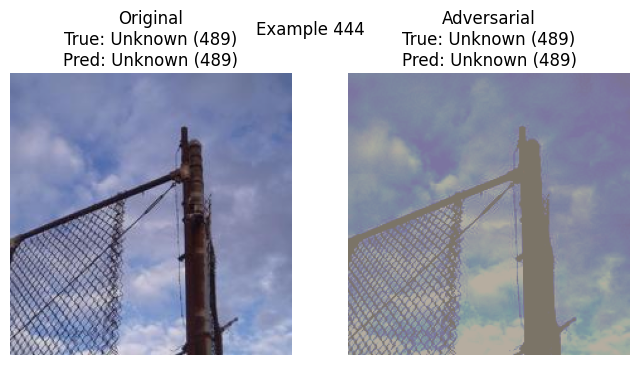

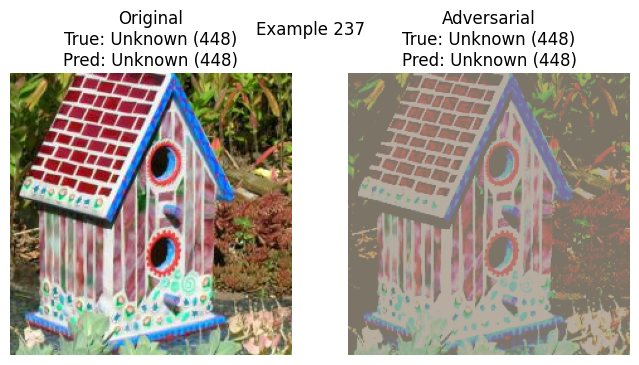

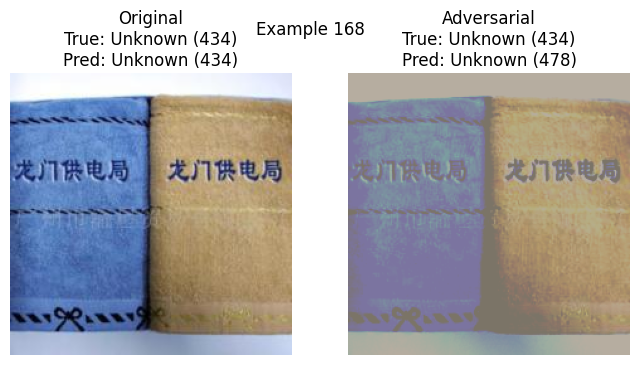

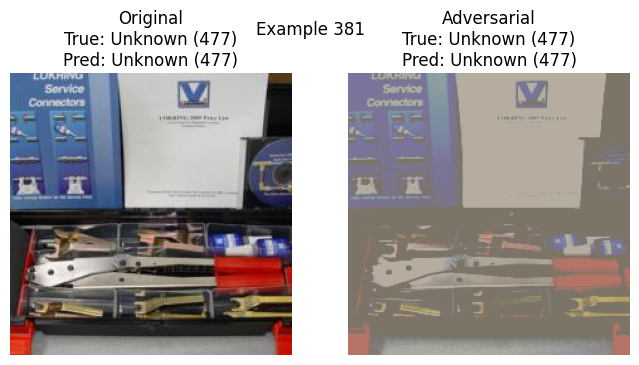

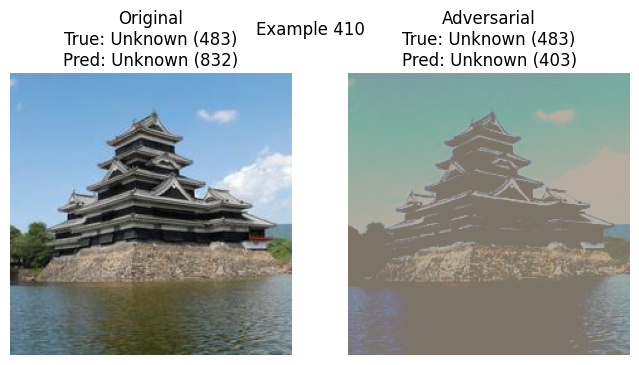

In [ ]:
num_examples = 5
indices = np.random.choice(len(adv_images), num_examples, replace=False)

for idx in indices:
    orig = dataset[idx][0].cuda().unsqueeze(0)
    adv = adv_images[idx].cuda().unsqueeze(0)
    label = adv_labels[idx].item()

    with torch.no_grad():
        orig_pred = model(orig).argmax(1).item()
        adv_pred = model(adv).argmax(1).item()

    orig_class = label_map.get(str(orig_pred), f"Unknown ({orig_pred})")
    adv_class = label_map.get(str(adv_pred), f"Unknown ({adv_pred})")
    true_class = label_map.get(str(label), f"Unknown ({label})")

    plot_comparison(orig.squeeze(), adv.squeeze(), orig_class, adv_class, true_class, idx)


## Task 3: Iterative FGSM/PGD Attack
Adjustable hyperparameters:
* epsilon - ϵ
* alpha - α
* iters - iterations/steps

| Increase ε → | Stronger attacks but riskier visually | <br>
| Increase α → | Faster movement, but needs to be balanced | <br>
| Increase iters → | More refined, better attacks but takes longer |

In [ ]:
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    images = images.clone().detach().to(images.device)
    ori_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()
    return images


### Generate adversarial test set 2

In [ ]:
adv_images_pgd = []
adv_labels_pgd = []

for images, labels in tqdm(dataloader):
    images, labels = images.cuda(), labels.cuda()
    mapped_labels = torch.tensor(
        [local_to_imagenet[l.item()] for l in labels],
        device=labels.device
    )
    perturbed_images = pgd_attack(model, images, mapped_labels, epsilon=0.01, alpha=0.005, iters=10)
    adv_images_pgd.append(perturbed_images.detach().cpu())
    adv_labels_pgd.append(mapped_labels.detach().cpu())

adv_images_pgd = torch.cat(adv_images_pgd)
adv_labels_pgd = torch.cat(adv_labels_pgd)

torch.save({'images': adv_images_pgd, 'labels': adv_labels_pgd}, 'adversarial_testset2.pt')

100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


### Evaluate Adversarial Test Set 2

In [ ]:
adv_dataset_pgd = torch.utils.data.TensorDataset(adv_images_pgd, adv_labels_pgd)
adv_loader_pgd = torch.utils.data.DataLoader(adv_dataset_pgd, batch_size=32, shuffle=False)

top1_pgd = 0
top5_pgd = 0
total = 0

with torch.no_grad():
  for images, labels in tqdm(adv_loader_pgd):
      images, labels = images.cuda(), labels.cuda()  # labels now are ImageNet indices
      outputs = model(images)
      _, preds = outputs.topk(5, 1, True, True)

      top1_pgd += (preds[:, 0] == labels).sum().item()
      top5_pgd += sum([labels[i] in preds[i] for i in range(labels.size(0))])
      total += labels.size(0)

top1_acc_pgd = top1_pgd / total * 100
top5_acc_pgd = top5_pgd / total * 100

print(f"PGD Adversarial Top-1 Accuracy: {top1_acc_pgd:.2f}%")
print(f"PGD Adversarial Top-5 Accuracy: {top5_acc_pgd:.2f}%")


100%|██████████| 16/16 [00:00<00:00, 18.38it/s]

PGD Adversarial Top-1 Accuracy: 4.00%
PGD Adversarial Top-5 Accuracy: 18.80%


### Visuals for Adversarial test set 2

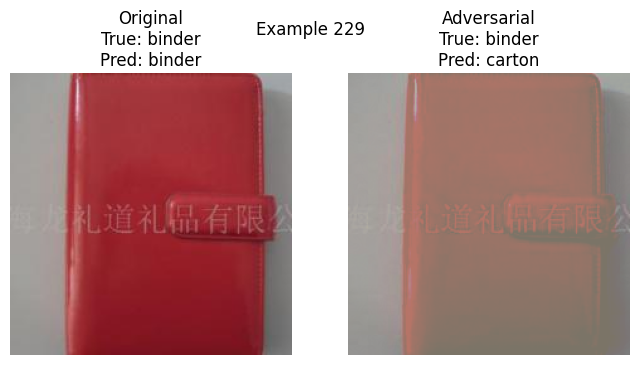

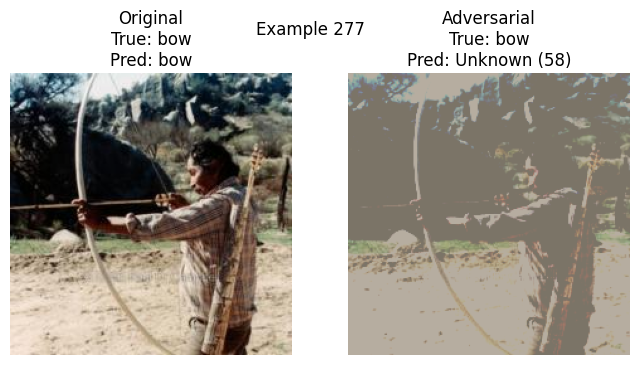

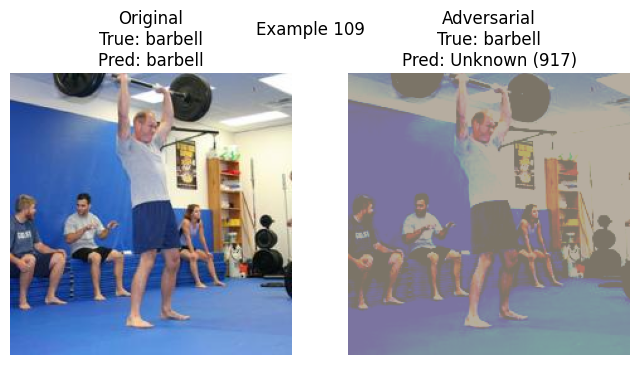

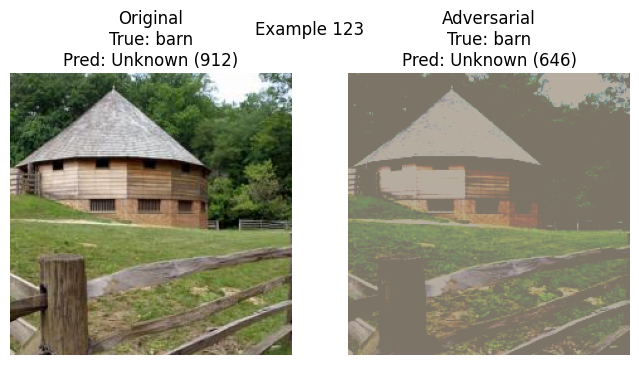

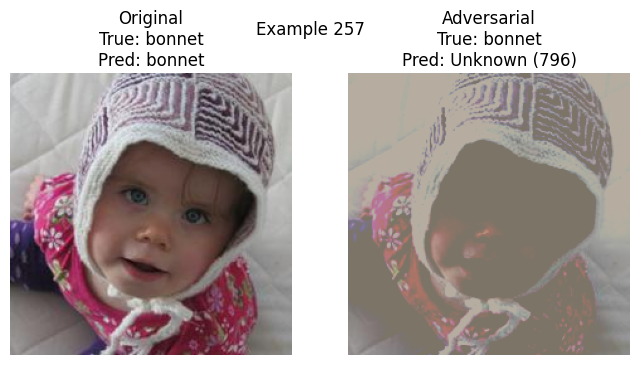

In [ ]:
# Choose some indices to visualize
num_examples = 5
indices = np.random.choice(len(adv_images_pgd), num_examples, replace=False)

for idx in indices:
    orig = dataset[idx][0].cuda().unsqueeze(0)
    adv = adv_images_pgd[idx].cuda().unsqueeze(0)
    label = adv_labels_pgd[idx].item()

    with torch.no_grad():
        orig_pred = model(orig).argmax(1).item()
        adv_pred = model(adv).argmax(1).item()

    orig_class = label_map.get(orig_pred, f"Unknown ({orig_pred})")
    adv_class = label_map.get(adv_pred, f"Unknown ({adv_pred})")
    true_class = label_map.get(label, f"Unknown ({label})")

    plot_comparison(orig.squeeze(), adv.squeeze(), orig_class, adv_class, true_class, idx)

## Task 4: Patch PGD Attack (fixed target)

In [ ]:
def patch_pgd_attack(model, images, target_class, epsilon, alpha, iters, patch_size, x_start, y_start):
    images = images.clone().detach()
    ori_images = images.clone().detach()

    batch_size, c, h, w = images.shape

    target_labels = torch.full((batch_size,), target_class, dtype=torch.long, device=images.device)

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, target_labels)
        model.zero_grad()
        loss.backward()

        grad = images.grad.data

        perturbed_images = images.clone().detach()
        for j in range(batch_size):
            xs, ys = x_start[j], y_start[j]
            perturbed_images[j, :, ys:ys+patch_size, xs:xs+patch_size] += alpha * grad[j, :, ys:ys+patch_size, xs:xs+patch_size].sign()
            eta = torch.clamp(perturbed_images[j] - ori_images[j], min=-epsilon, max=epsilon)
            perturbed_images[j] = torch.clamp(ori_images[j] + eta, min=0, max=1)

        images = perturbed_images.clone().detach()

    return images


### Generate Adversarial Test Set 3

In [ ]:
target_class = local_to_imagenet[5]  # you can pick any ImageNet class index, e.g., 5
epsilon = 0.5
alpha = 0.02
iters = 20
patch_size = 32
adv_images_patch = []
adv_labels_patch = []
x_start_all = []
y_start_all = []

for images, labels in tqdm(dataloader):
    images, labels = images.cuda(), labels.cuda()
    batch_size = images.shape[0]

    mapped_labels = torch.tensor(
    [local_to_imagenet[l.item()] for l in labels],
    device=labels.device)

    # Generate random patch positions once per batch
    x_start = torch.randint(0, images.shape[3] - patch_size + 1, (batch_size,), device=images.device)
    y_start = torch.randint(0, images.shape[2] - patch_size + 1, (batch_size,), device=images.device)

    # Save positions (on CPU for storage)
    x_start_all.append(x_start.cpu())
    y_start_all.append(y_start.cpu())

    perturbed_images = patch_pgd_attack(model, images, target_class, epsilon, alpha, iters, patch_size, x_start, y_start)
    adv_images_patch.append(perturbed_images.detach().cpu())
    adv_labels_patch.append(mapped_labels.detach().cpu())

adv_images_patch = torch.cat(adv_images_patch)
adv_labels_patch = torch.cat(adv_labels_patch)
x_start_all = torch.cat(x_start_all)
y_start_all = torch.cat(y_start_all)

torch.save({
    'images': adv_images_patch,
    'labels': adv_labels_patch,
    'x_start': x_start_all,
    'y_start': y_start_all
}, 'adversarial_testset3.pt')


100%|██████████| 16/16 [00:49<00:00,  3.07s/it]


### Evaluate Accuracy

In [ ]:
adv_dataset_patch = torch.utils.data.TensorDataset(adv_images_patch, adv_labels_patch)
adv_loader_patch = torch.utils.data.DataLoader(adv_dataset_patch, batch_size=32, shuffle=False)

top1_patch = 0
top5_patch = 0
total = 0

with torch.no_grad():
  for images, labels in tqdm(adv_loader_patch):
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, preds = outputs.topk(5, 1, True, True)

      top1_patch += (preds[:, 0] == labels).sum().item()
      top5_patch += sum([labels[i] in preds[i] for i in range(labels.size(0))])
      total += labels.size(0)


top1_acc_patch = top1_patch / total * 100
top5_acc_patch = top5_patch / total * 100

print(f"Patch Attack Top-1 Accuracy: {top1_acc_patch:.2f}%")
print(f"Patch Attack Top-5 Accuracy: {top5_acc_patch:.2f}%")


100%|██████████| 16/16 [00:00<00:00, 18.00it/s]


Patch Attack Top-1 Accuracy: 37.80%
Patch Attack Top-5 Accuracy: 58.60%


### Visualization for Task 4

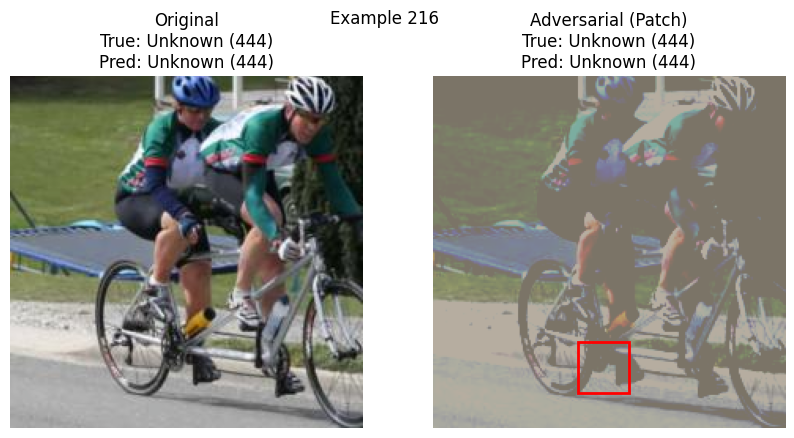

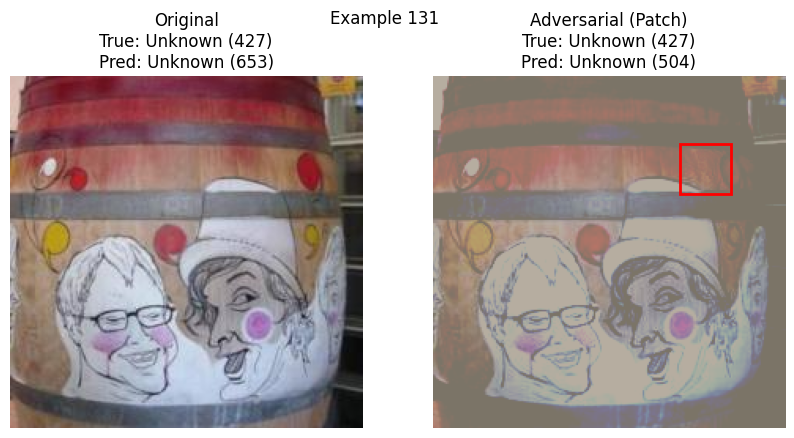

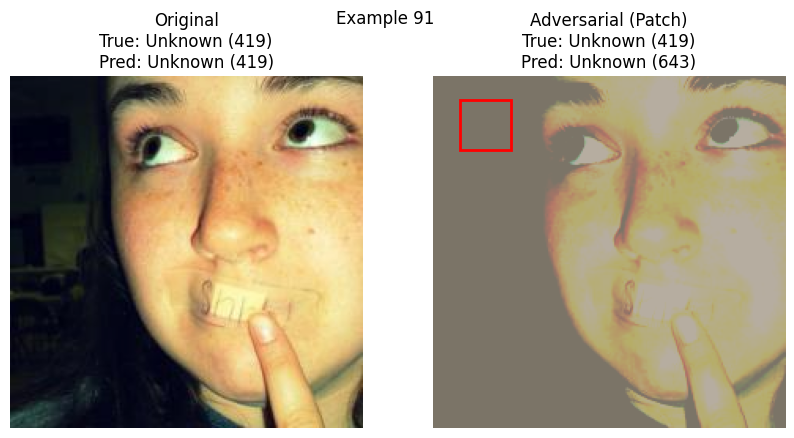

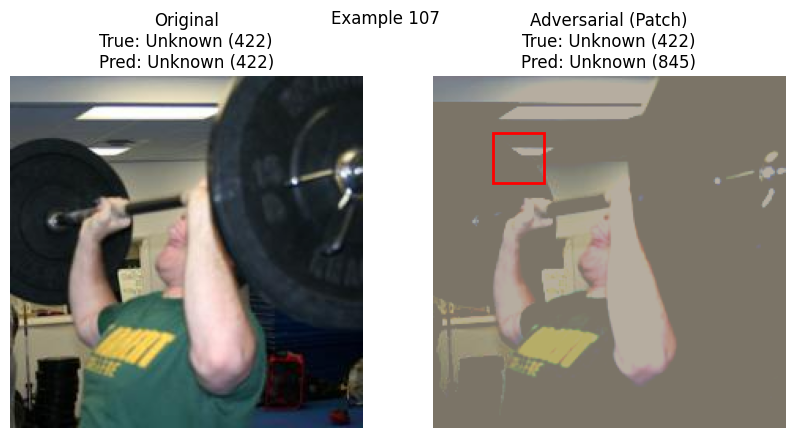

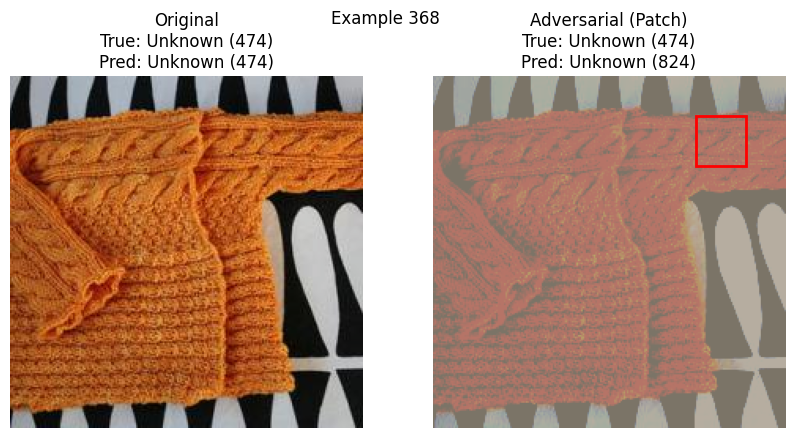

In [ ]:
# Load saved adversarial patch dataset
data = torch.load('adversarial_testset3.pt')
adv_images_patch = data['images']
adv_labels_patch = data['labels']
x_start_all = data['x_start']
y_start_all = data['y_start']

num_examples = 5
indices = np.random.choice(len(adv_images_patch), num_examples, replace=False)

for idx in indices:
    orig = original_dataset[idx][0].cuda().unsqueeze(0)  # original clean image
    adv = adv_images_patch[idx].cuda().unsqueeze(0)  # adversarial patch image
    label = adv_labels_patch[idx].item()

    x_start = x_start_all[idx].item()
    y_start = y_start_all[idx].item()

    with torch.no_grad():
        orig_pred = model(orig).argmax(1).item()
        adv_pred = model(adv).argmax(1).item()

    orig_class = label_map.get(str(orig_pred), f"Unknown ({orig_pred})")
    adv_class = label_map.get(str(adv_pred), f"Unknown ({adv_pred})")
    true_class = label_map.get(str(label), f"Unknown ({label})")

    plot_patch_comparison(
        orig.squeeze(), adv.squeeze(),
        orig_class, adv_class, true_class,
        idx, x_start, y_start, patch_size=32
    )

# Task 5: Evaluate another Model with these 3 Adversarial Datasets - ResNet-50

## Load ResNet-50

In [57]:
new_model = torchvision.models.resnet50(weights='IMAGENET1K_V1').eval().cuda()

In [58]:
def make_loader(dataset_dict):
    images = dataset_dict['images']
    labels = dataset_dict['labels']

    # If they’re numpy, convert to torch tensors
    if isinstance(images, np.ndarray):
        images = torch.tensor(images)
    if isinstance(labels, np.ndarray):
        labels = torch.tensor(labels)

    adv_dataset = torch.utils.data.TensorDataset(images, labels)
    return torch.utils.data.DataLoader(adv_dataset, batch_size=32, shuffle=False)

# Load saved adversarial datasets
fgsm_data = torch.load('adversarial_testset1.pt')
pgd_data = torch.load('adversarial_testset2.pt')
patch_data = torch.load('adversarial_testset3.pt')

In [59]:
fgsm_loader = make_loader(fgsm_data)
pgd_loader = make_loader(pgd_data)
patch_loader = make_loader(patch_data)
original_loader = torch.utils.data.DataLoader(original_dataset, batch_size=32, shuffle=False)


In [60]:
def evaluate_model(model, loader, local_to_imagenet=None):
    top1 = 0
    top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.cuda(), labels.cuda()

            if local_to_imagenet is not None:
                mapped_labels = torch.tensor(
                    [local_to_imagenet[l.item()] for l in labels],
                    device=labels.device
                )
            else:
                mapped_labels = labels  # assume labels already in ImageNet space

            outputs = model(images)
            _, preds = outputs.topk(5, 1, True, True)

            top1 += (preds[:, 0] == mapped_labels).sum().item()
            top5 += sum([mapped_labels[i] in preds[i] for i in range(labels.size(0))])
            total += labels.size(0)

    top1_acc = top1 / total * 100
    top5_acc = top5 / total * 100
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")


In [61]:
def visualize_examples(model, dataset_dict, label_map, indices=None, num_examples=5):
    images = dataset_dict['images']
    labels = dataset_dict['labels']

    if indices is None:
        indices = np.random.choice(len(images), num_examples, replace=False)

    for idx in indices:
        adv = images[idx].unsqueeze(0).cuda()
        label = labels[idx].item()

        with torch.no_grad():
            adv_pred = model(adv).argmax(1).item()

        adv_class = label_map.get(str(adv_pred), f"Unknown ({adv_pred})")
        true_class = label_map.get(str(label), f"Unknown ({label})")

        # If you have original dataset, load here; else just plot adv
        adv_img = unnormalize(adv.squeeze().cpu(), mean_norms, std_norms).permute(1, 2, 0).numpy()

        plt.figure(figsize=(3, 3))
        plt.imshow(np.clip(adv_img, 0, 1))
        plt.title(f"True: {true_class}\nPred: {adv_class}")
        plt.axis('off')
        plt.show()


### Run on each dataset

In [65]:
# Original
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(original_loader):
        images, labels = images.cuda(), labels.cuda()

        mapped_labels = torch.tensor(
            [local_to_imagenet[l.item()] for l in labels],
            device=labels.device
        )

        outputs = new_model(images)
        _, preds = outputs.topk(5, 1, True, True)

        top1_correct += (preds[:, 0] == mapped_labels).sum().item()
        top5_correct += sum([mapped_labels[i] in preds[i] for i in range(labels.size(0))])
        total += labels.size(0)

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"ResNet-50 on Original Dataset - Top-1 Accuracy: {top1_acc:.2f}%")
print(f"ResNet-50 on Original Dataset - Top-5 Accuracy: {top5_acc:.2f}%")


100%|██████████| 16/16 [00:02<00:00,  5.51it/s]

ResNet-50 on Original Dataset - Top-1 Accuracy: 80.20%
ResNet-50 on Original Dataset - Top-5 Accuracy: 94.60%


Evaluating on FGSM set:


100%|██████████| 16/16 [00:01<00:00, 10.21it/s]


Top-1 Accuracy: 38.80%
Top-5 Accuracy: 56.40%


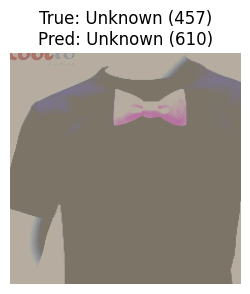

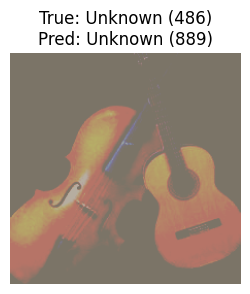

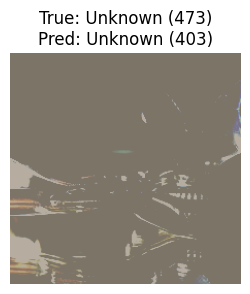

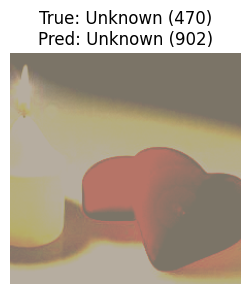

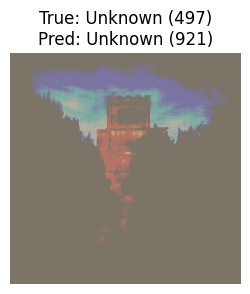

In [63]:
# Adversarial Test Set 1
print("Evaluating on FGSM set:")
evaluate_model(new_model, fgsm_loader)
visualize_examples(new_model, fgsm_data, label_map)


Evaluating on PGD set:


100%|██████████| 16/16 [00:01<00:00, 10.05it/s]


Top-1 Accuracy: 36.20%
Top-5 Accuracy: 54.60%


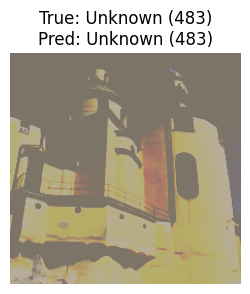

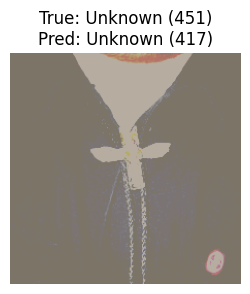

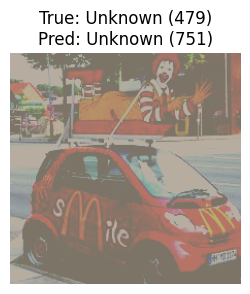

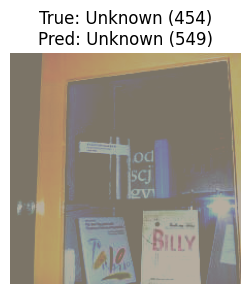

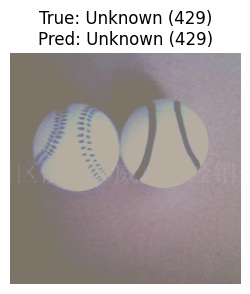

In [64]:
# Adversarial Test Set 2
print("\nEvaluating on PGD set:")
evaluate_model(new_model, pgd_loader)
visualize_examples(new_model, pgd_data, label_map)


Evaluating on Patch PGD set:


100%|██████████| 16/16 [00:01<00:00, 10.51it/s]


Top-1 Accuracy: 42.20%
Top-5 Accuracy: 60.00%


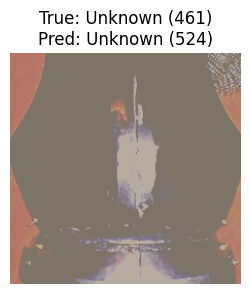

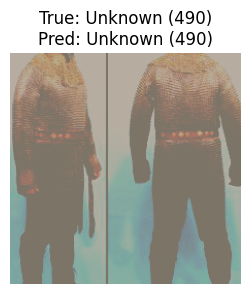

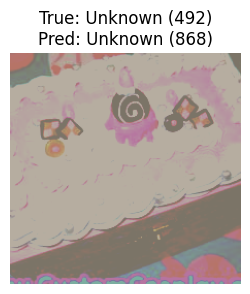

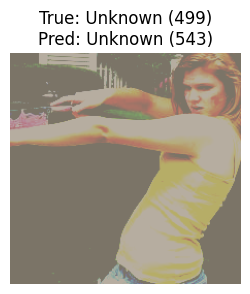

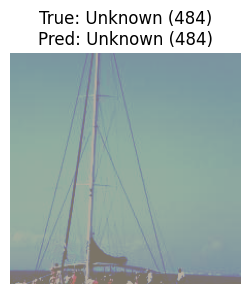

In [ ]:
# Adversarial Test Set 3
print("\nEvaluating on Patch PGD set:")
evaluate_model(new_model, patch_loader)
visualize_examples(new_model, patch_data, label_map)